In [2]:
%load_ext line_profiler

[(16, 15, 1.0), (17, 13, 2.8284271247461903), (18, 12, 4.242640687119285), (11, 12, 5.0)]


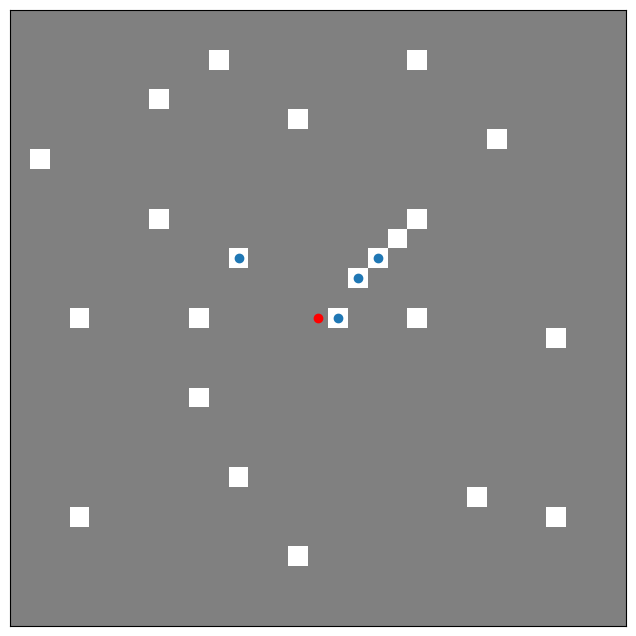

In [3]:
import sys
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy
import numpy as np
import math
from scipy.spatial import Delaunay

sys.path.append("/home/matthias/Documents/inpainting_ss2024_Pijarowski_Matthias/cpp")

import example

defined      = 0
undefined    = 255

mask  = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE )

def find_nearest_neighbors_brute_force( coordinate, mask, k, axis=None, Debug=False ):
    x_origin,y_origin = coordinate
    candidates = []
    for y in range(mask.shape[1]):
        for x in range(mask.shape[0]):
            if x_origin == x and y_origin == y:
                continue
            if mask[y,x] == defined:
                dx = x-x_origin
                dy = y-y_origin
                distance = numpy.sqrt( dx*dx+dy*dy )
                candidates.append( ( x, y, distance ) )
    candidates = sorted( candidates, key=lambda x: x[2] )
    return candidates[0:k]

def display_neightbors( axis, mask, origin, neighbors ):
    axis.imshow(mask, cmap='Greys', alpha=0.5)
    X = [x for x,_,_ in neighbors ]
    Y = [y for _,y,_ in neighbors ]
    ox,oy = origin
    axis.scatter( x=[ox],y=[oy], c="red" )
    axis.scatter( x=X,y=Y )
    axis.set_xticks([])
    axis.set_yticks([])

origin = (15,15)
neighbors = find_nearest_neighbors_brute_force( origin, mask, 4, None, True ) 
print( neighbors )

fig,axis = plt.subplots( 1, 1, figsize=(16,8) )
display_neightbors( axis, mask, origin, neighbors )
plt.savefig("knn_search_brute_force.png")
plt.show()

In [4]:
def display_neighbors(mask, origin, neighbors):
    fig,axis = plt.subplots( 1, 1, figsize=(8,8) )
    axis.imshow(mask, cmap='Greys', alpha=0.5)
    X = [neighour[1] for neighour in neighbors]
    Y = [neighour[0] for neighour in neighbors]
    oy,ox = origin
    axis.scatter( x=[ox],y=[oy], c="red" )
    axis.scatter( x=X,y=Y )
    plt.show()

In [5]:
def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)


def find_nearest_neighbors_quadratic(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int, float]]:
    origin_y, origin_x = origin
    height, width = mask.shape
    neighbors = []

    for distance in range(1, mask.shape[0] // 2 + 1):
        pixels_to_process = []
        tl_y, tl_x = origin_y - distance, origin_x - distance
        br_y, br_x = origin_y + distance, origin_x + distance

        for y in range(tl_y, br_y + 1):
            if 0 <= y < height:
                if tl_x >= 0:
                    pixels_to_process.append((y, tl_x))
                if br_x < width:
                    pixels_to_process.append((y, br_x))

        for x in range(tl_x + 1, br_x):
            if 0 <= x < width:
                if tl_y >= 0:
                    pixels_to_process.append((tl_y, x))
                if br_y < height:
                    pixels_to_process.append((br_y, x))

        for y, x in pixels_to_process:
            if mask[y, x] == defined:
                distance = euclidean_distance(origin, (y, x))
                if len(neighbors) < k:
                    neighbors.append((y, x, distance))
                elif len(neighbors) == k and distance < neighbors[-1][2]:
                    neighbors.pop()
                    neighbors.append((y, x, distance))
                neighbors = sorted(neighbors, key=lambda tup: tup[2])

    return neighbors

In [6]:
def find_nearest_neighbors_circle(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int]]:
    origin_y, origin_x = origin
    height, width = mask.shape

    d_tl, d_bl, d_tr, d_br = (euclidean_distance(origin, (0, 0)), 
                              euclidean_distance(origin, (height, 0)), 
                              euclidean_distance(origin, (0, width)), 
                              euclidean_distance(origin, (height, width)))

    thetas = np.linspace(0, 2, 360, endpoint=False) * np.pi
    neighbors = set()

    for radius in range(1, round(max([d_tl, d_bl, d_tr, d_br]))):
        Y = np.round(radius * np.cos(thetas) + origin_y).astype(int)
        X = np.round(radius * np.sin(thetas) + origin_x).astype(int)
        for y, x in zip(Y, X):
            if mask[y, x] == defined and 0 <= y < height and 0 <= x < width:
                neighbors.add((y, x))
                if len(neighbors) == k:
                    return list(neighbors)

    return list(neighbors)


# %lprun -f find_nearest_neighbors_circle find_nearest_neighbors_circle(mask=mask, origin=origin, k=4)
# origin = (15, 15)
# image = np.full((31, 31), 255)
# image[0, 0] = 0
# image[0, 30] = 0
# image[30, 0] = 0
# image[30, 30] = 0
# neighbors = find_nearest_neighbors_circle(image, origin, 4)
# display_neighbors(image, origin, neighbors)


In [7]:
def find_nearest_neighbors_graph(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int]]:
    points = [origin] + (np.argwhere(mask == defined).tolist())
    delauny = Delaunay(points)
    return

origin = (15, 15)
neighbors = find_nearest_neighbors_graph(mask, origin, 4)

In [8]:
import unittest

class TestKNN(unittest.TestCase):
    def make_display(self, mask, origin, neighbours):
        fig, axis = plt.subplots( 1, 1, figsize=(16,8) )
        axis.imshow(mask, cmap='Greys', alpha=0.5)
        X = [x for _, x, _ in neighbours ]
        Y = [y for y, _, _ in neighbours ]
        oy,ox = origin
        axis.scatter( x=[ox],y=[oy], c="red" )
        axis.scatter( x=X,y=Y )
        axis.set_xticks([])
        axis.set_yticks([])
        plt.show()

    def test_bruteforce(self):
        neighbors = find_nearest_neighbors_brute_force( origin, mask, 4, None, True )
        neighbors = sorted([(y, x) for y, x, _ in neighbors])
        gt = sorted([(16, 15), (17, 13), (18, 12), (11, 12)])

        self.assertCountEqual(neighbors, gt)

    def test_quadatic(self):
        gt = sorted([(15, 16), (13, 17), (12, 18), (12, 11)])

        neighbors = find_nearest_neighbors_quadratic(mask, origin, 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        self.assertCountEqual(neighbors_, gt)
        # self.make_display(mask, origin, neighbors)

    def test_quadratic_edge(self):
        im = np.array([[255, 255, 255, 255, 0, 255, 255, 255, 255],
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 0], 
               [0, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 0, 255, 255, 255, 255], 
               ])
        gt = sorted([(3, 8), (1, 7), (7, 7), (0, 4)])
        neighbors = find_nearest_neighbors_quadratic(im, (4, 8), 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        self.assertCountEqual(neighbors_, gt)
        # self.make_display(im, (4, 8), neighbors)

    def test_quadratic_middle(self):
        im = np.array([[255, 255, 255, 255, 0, 255, 255, 255, 255],
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 0], 
               [0, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 0, 255, 255, 255, 255], 
               ])
        gt = sorted([(4, 0), (0, 4), (8, 4), (3, 8)])
        neighbors = find_nearest_neighbors_quadratic(im, (4, 4), 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        # self.make_display(im, (4, 4), neighbors)
        self.assertCountEqual(neighbors_, gt)

unittest.main(argv=[""], verbosity=2, exit=False)

test_bruteforce (__main__.TestKNN.test_bruteforce) ... ok
test_quadatic (__main__.TestKNN.test_quadatic) ... ok
test_quadratic_edge (__main__.TestKNN.test_quadratic_edge) ... ok
test_quadratic_middle (__main__.TestKNN.test_quadratic_middle) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


In [10]:
origin = (200, 200)
test_image = np.random.rand(160000).reshape((400, 400))
test_image = np.where(test_image < 0.01, 0, 255)

neighbors = find_nearest_neighbors_circle(mask=test_image, origin=origin, k=4)
# display_neighbors(test_image, origin, neighbors)

%lprun -f find_nearest_neighbors_circle find_nearest_neighbors_circle(mask=test_image, origin=origin, k=4)

Timer unit: 1e-09 s

Total time: 0.00204943 s
File: /tmp/ipykernel_7750/1113952817.py
Function: find_nearest_neighbors_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def find_nearest_neighbors_circle(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int]]:
     2         1        661.0    661.0      0.0      origin_y, origin_x = origin
     3         1        782.0    782.0      0.0      height, width = mask.shape
     4                                           
     5         2       8506.0   4253.0      0.4      d_tl, d_bl, d_tr, d_br = (euclidean_distance(origin, (0, 0)), 
     6         1       2345.0   2345.0      0.1                                euclidean_distance(origin, (height, 0)), 
     7         1       1674.0   1674.0      0.1                                euclidean_distance(origin, (0, width)), 
     8         1       1453.0   1453.0      0.1                         

In [11]:
%lprun -f example.nn_circular example.nn_circular(test_image, origin, 4)

Timer unit: 1e-09 s

Total time: 0.00328037 s
File: /tmp/ipykernel_7750/1113952817.py
Function: find_nearest_neighbors_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def find_nearest_neighbors_circle(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int]]:
     2         1       1613.0   1613.0      0.0      origin_y, origin_x = origin
     3         1       3116.0   3116.0      0.1      height, width = mask.shape
     4                                           
     5         2      37540.0  18770.0      1.1      d_tl, d_bl, d_tr, d_br = (euclidean_distance(origin, (0, 0)), 
     6         1       8285.0   8285.0      0.3                                euclidean_distance(origin, (height, 0)), 
     7         1       6122.0   6122.0      0.2                                euclidean_distance(origin, (0, width)), 
     8         1       5831.0   5831.0      0.2                         